In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/Project_B_Supp/mhist_models')

Mounted at /content/drive


In [ ]:
#_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
#PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

#train_dir = os.path.join(PATH, 'train')
#validation_dir = os.path.join(PATH, 'validation')

train_dir ='/content/drive/My Drive/Project_B_Supp/mhist_dataset/train/'
validation_dir =  '/content/drive/My Drive/Project_B_Supp/mhist_dataset/test/'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2175 files belonging to 2 classes.
Found 977 files belonging to 2 classes.


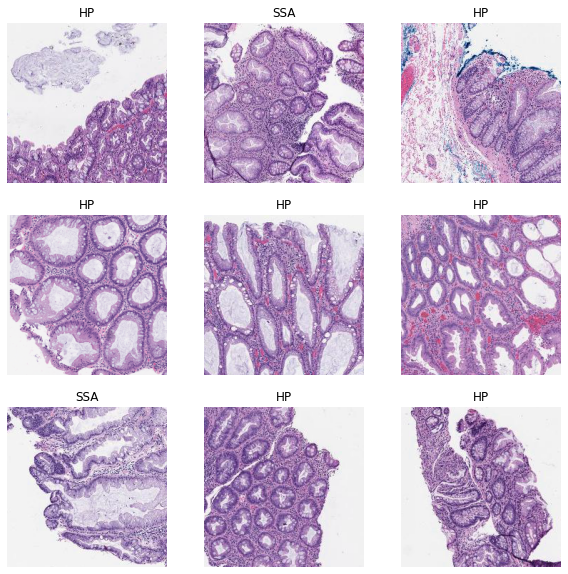

In [ ]:
# Show some images for validation
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#create a test batch to check model functionality at the end of fine tuning
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 25
Number of test batches: 6


In [ ]:
#optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#add data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

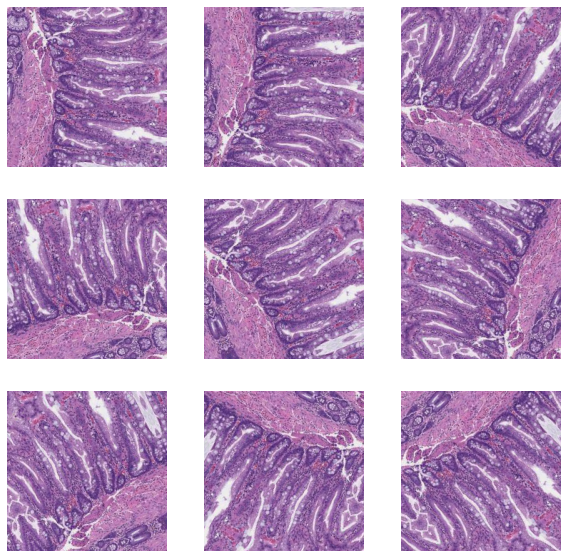

In [ ]:
#show data augmentation for validation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#add preprocessing layer to make sure proper dimensions for model, if data augmentation changed them
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
#freeze convolutional layers
base_model.trainable = False
#reduce data dimension for classification layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#add classification layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [ ]:
#connect model layers together
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Deviating from tutorial starting here

In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
#compilation
training_temp = 16
training_alpha = 0.75
teacher = tf.keras.models.load_model('teacher_model',compile=False)
distiller = Distiller(student=model,teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    alpha=training_alpha,
    temperature = training_temp,
    distillation_loss_fn=tf.keras.losses.KLDivergence( )
)

In [ ]:
# Distill teacher to student
history = distiller.fit(train_dataset, 
                        epochs=10,
                        validation_data=validation_dataset)

Epoch 1/10
68/68 [==============================] - 181s 3s/step - accuracy: 0.7094 - student_loss: 0.5794 - val_accuracy: 0.7210 - val_student_loss: 0.2788
Epoch 2/10
68/68 [==============================] - 10s 139ms/step - accuracy: 0.7697 - student_loss: 0.4599 - val_accuracy: 0.7108 - val_student_loss: 0.5414
Epoch 3/10
68/68 [==============================] - 10s 139ms/step - accuracy: 0.7963 - student_loss: 0.4214 - val_accuracy: 0.7554 - val_student_loss: 0.3074
Epoch 4/10
68/68 [==============================] - 10s 137ms/step - accuracy: 0.8009 - student_loss: 0.4048 - val_accuracy: 0.7236 - val_student_loss: 0.8128
Epoch 5/10
68/68 [==============================] - 10s 140ms/step - accuracy: 0.8069 - student_loss: 0.4022 - val_accuracy: 0.7439 - val_student_loss: 0.2709
Epoch 6/10
68/68 [==============================] - 10s 139ms/step - accuracy: 0.8106 - student_loss: 0.3842 - val_accuracy: 0.7554 - val_student_loss: 0.2603
Epoch 7/10
68/68 [==============================

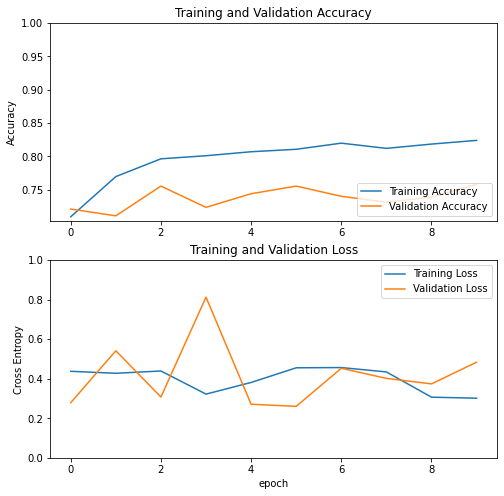

In [ ]:
#plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['student_loss']
val_loss = history.history['val_student_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#unfreeze convolutional layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile model
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'],
    student_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    alpha=training_alpha,
    temperature = training_temp,
    distillation_loss_fn=tf.keras.losses.KLDivergence()
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#fine tune model
fine_tune_epochs = 25
total_epochs =  10 + fine_tune_epochs

history_fine = distiller.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/35
68/68 [==============================] - 16s 153ms/step - accuracy: 0.7163 - student_loss: 0.5614 - val_accuracy: 0.6382 - val_student_loss: 0.6817
Epoch 11/35
68/68 [==============================] - 10s 142ms/step - accuracy: 0.7536 - student_loss: 0.4666 - val_accuracy: 0.7694 - val_student_loss: 0.4072
Epoch 12/35
68/68 [==============================] - 10s 140ms/step - accuracy: 0.7926 - student_loss: 0.4063 - val_accuracy: 0.7287 - val_student_loss: 0.7481
Epoch 13/35
68/68 [==============================] - 10s 140ms/step - accuracy: 0.8078 - student_loss: 0.3928 - val_accuracy: 0.7720 - val_student_loss: 0.8671
Epoch 14/35
68/68 [==============================] - 10s 142ms/step - accuracy: 0.8184 - student_loss: 0.3810 - val_accuracy: 0.7669 - val_student_loss: 0.3513
Epoch 15/35
68/68 [==============================] - 10s 141ms/step - accuracy: 0.8271 - student_loss: 0.3585 - val_accuracy: 0.8127 - val_student_loss: 0.5459
Epoch 16/35
68/68 [=====================

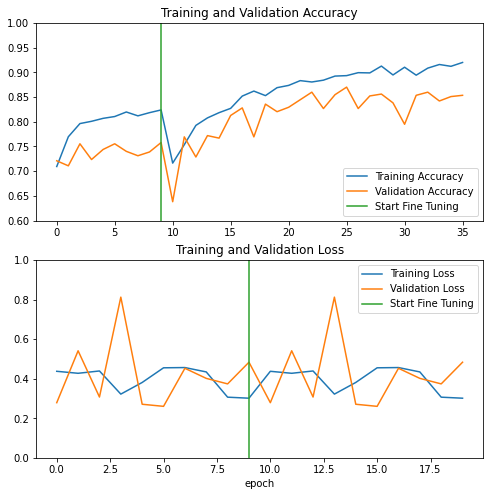

In [ ]:
# update metrics
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history.history['student_loss']
val_loss += history.history['val_student_loss']

# plot updated learning curves
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Evaluate performance
temp = distiller.evaluate(test_dataset)
print('Test accuracy :', temp[0])

6/6 [==============================] - 1s 88ms/step - accuracy: 0.8854 - student_loss: 0.2606
Test accuracy : 0.8854166865348816


Predictions:
 [0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0]
Labels:
 [1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]


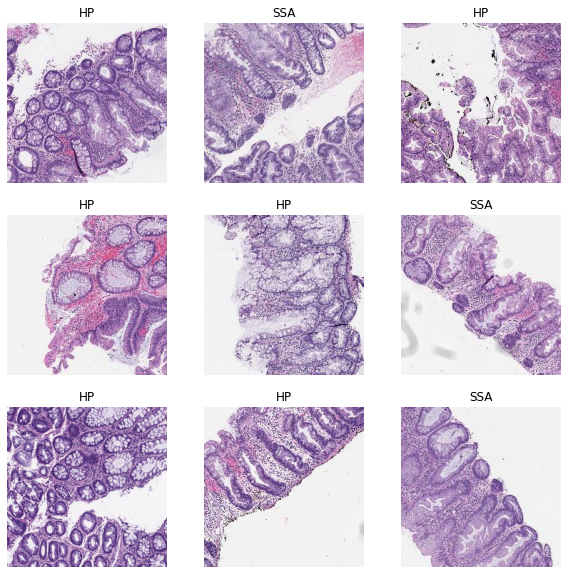

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
#save model
model.save('student_KD_model')

INFO:tensorflow:Assets written to: student_KD_model/assets
